<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritzKokiU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bambi
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import bambi as bmb
import xarray as xr

**Intro**

In this project, I will be examining the baseball statistic WAR (Wins Above Replacement). This is an advanced baseball stat that basically shows how "valuable" a player is to a team by determining how many more wins they are worth than a replacement-level player of the same position. This means a very replaceable player would have a WAR of 0.

WAR is calculated with this equation:

The number of runs above average a player is worth in his batting, baserunning and fielding + adjustment for position + adjustment for league + the number of runs provided by a replacement-level player) / runs per win

In [3]:
#the data from a spreadsheet made by Ben Gaskins
bbdata = pd.read_csv('https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv', header=0)
bbdata

,k,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos
0,1.0,Jarren Duran*,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,...,129.0,0.373,134.0,330.0,6.0,6.0,1.0,3.0,1.0,OF
1,2.0,Shohei Ohtani*,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,...,190.0,0.449,190.0,411.0,7.0,6.0,0.0,5.0,10.0,DH
2,3.0,Gunnar Henderson*,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,...,159.0,0.385,157.0,333.0,2.0,7.0,0.0,4.0,1.0,SS
3,4.0,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,...,100.0,0.310,100.0,254.0,9.0,3.0,0.0,1.0,2.0,2B
4,5.0,Juan Soto*,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,...,178.0,0.424,179.0,328.0,10.0,4.0,0.0,4.0,2.0,OF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,738.0,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
772,739.0,Kirby Yates*,37.0,TEX,AL,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
773,740.0,Alex Young*,30.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
774,741.0,Guillo Zuñiga,25.0,LAA,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


**The Variables**

The baseball statistics I will be using for my analysis will be Position (POS), Homeruns (HR), Hits (H), and Strikeouts (SO).

I chose position because even though WAR calculations are different for some positions, I thought position might play a role in how many hits and homeruns a player might get. For example, if a player is on the team for their extreme skill on defense, they might be lacking in other categories, such as hitting, making their WAR worse.

I chose homeruns because they are a decent single-stat measure of how good a player is offensively. I thought this might be closely intertwined with how "replaceable" a player is.

I chose hits for a similar reason as homeruns, that a lot of hits can also make a player very valuable offensively, even if the hits themselves aren't good enough to get a homerun.

I chose strikeouts because they are a negative offensive stat, constrasting the other positive ones I had.

In [4]:
bbdata = bbdata.query('PA>200') #removes all players under 200 played appearances
bbdata = bbdata[['Player', 'WAR', 'H', 'SO', 'HR', 'Pos']] #just columns I need and player names
bbdata

,Player,WAR,H,SO,HR,Pos
0,Jarren Duran*,8.7,191.0,160.0,21.0,OF
1,Shohei Ohtani*,9.2,197.0,162.0,54.0,DH
2,Gunnar Henderson*,9.1,177.0,159.0,37.0,SS
3,Marcus Semien,4.1,154.0,105.0,23.0,2B
4,Juan Soto*,7.9,166.0,119.0,41.0,OF
...,...,...,...,...,...,...
360,Trent Grisham*,0.4,34.0,57.0,9.0,OF
361,Kyle Stowers*,-0.5,40.0,74.0,3.0,UTIL
362,Jackson Holliday*,0.1,36.0,69.0,5.0,2B
363,Jorge Mateo,0.9,44.0,48.0,5.0,2B


In [5]:
#define the model
model_PosHR = bmb.Model("`WAR` ~ `H` + 'SO' + 'HR' + Pos + Pos:HR", data=bbdata)
#fit the model
idata_PosHR = model_PosHR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

My first model includes all my variables, with an interaction between position and homeruns.

In [6]:
model_noInt = bmb.Model("`WAR` ~ `H` + Pos + 'HR' + 'SO'", data=bbdata)
idata_noInt = model_noInt.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

My second model is the same as the first, but with no interactions.

In [7]:
model_HHR = bmb.Model("`WAR` ~ `H` + Pos + 'HR' + 'SO' + H:HR", data=bbdata)
idata_HHR = model_HHR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

My third model has an interaction between homeruns and hits.

In [8]:
model_PosH = bmb.Model("`WAR` ~ `H` + Pos + 'HR' + 'SO' + Pos:H", data=bbdata)
idata_PosH = model_PosH.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

My fourth and final model has an interaction between position and hits.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

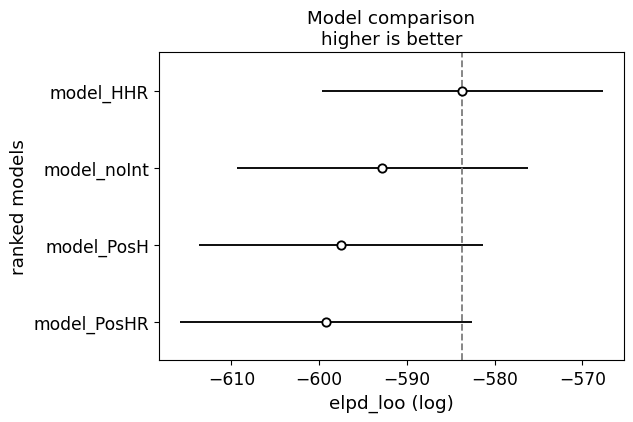

In [11]:
compare = az.compare({"model_PosHR":idata_PosHR, "model_noInt":idata_noInt, "model_HHR":idata_HHR, "model_PosH":idata_PosH})
az.plot_compare(compare)

**Which Model is Best**

After comparing, it is obvious that a model with an interaction between homeruns and hits is the best. I also thought it was interesting that the models with position interactions were the worst two, meaning I was wrong in my initial idea that position would have an influence.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='H', ylabel='WAR'>], dtype=object))

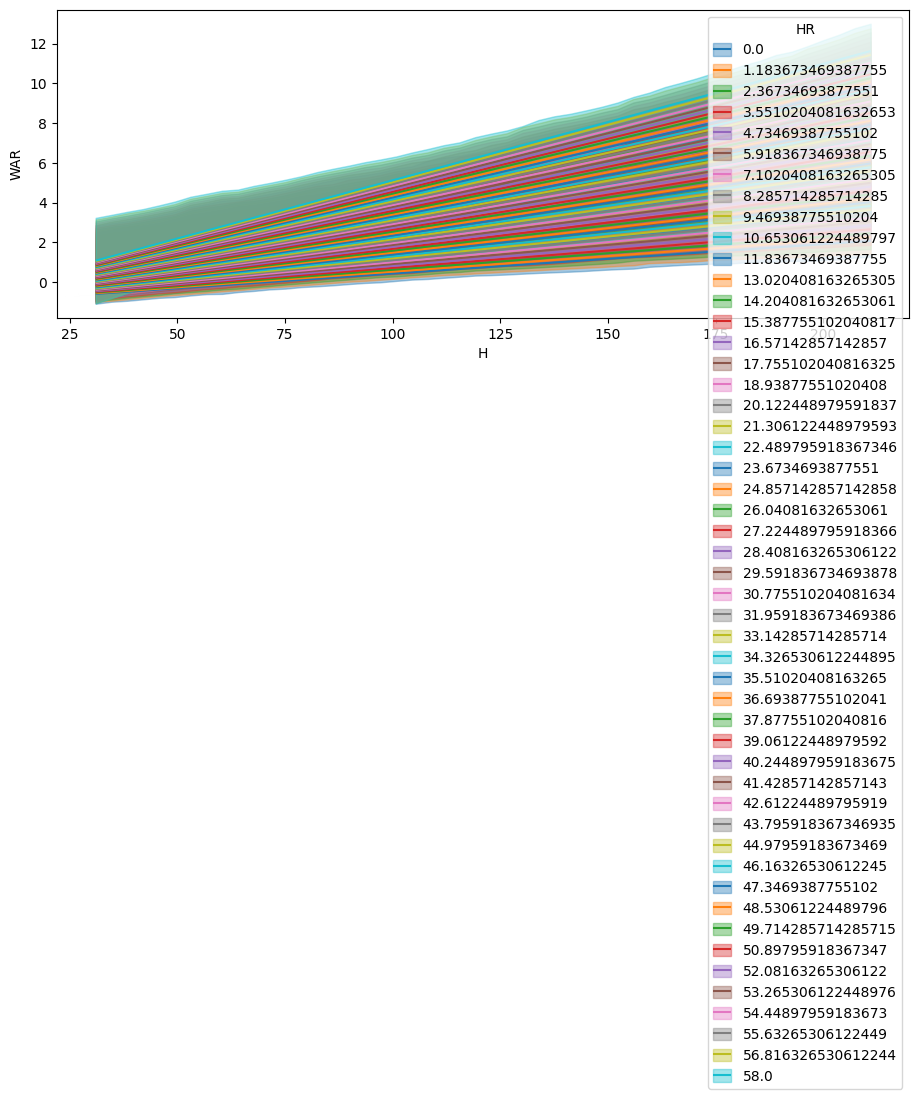

In [12]:
bmb.interpret.plot_predictions(model_HHR,
                               idata_HHR,
                               ["H","HR"],
                               fig_kwargs={"figsize":(11, 4)})

**Conclusion**

My model shows that hits, although important for actual baseball, contribute to very little to no increase in WAR, if those hits aren't homeruns. For example Luis Arraez is the second best hitter in the league, yet he has very little homeruns, meaning his WAR is low, even though he is far from a replaceable player. At first glance, if a player's WAR is low, that player might be regarded as low skill by a person with little knowledge of the game. This model proves the idea that hitting for power is superior in baseball than hitting for contact.